# Correlation

### Story
SRA is hierarchically structures, with experiments (SRX) representing an individual library and runs (SRR) representing technical replicates of running a library on multiple lanes. It makes sense to collapse SRRs to the SRX level, but there is concern that sometimes SRRs within and SRX were are from separate libraries. To look for these types of relationships it makes sense to look at the correlation of SRRs within SRX and determine if they look like they are from the same library.

### Questions and Tasks
- [ ] Are there any examples where SRRs are poorly correlated?
- [ ] Are there any other features that would suggest why these SRRs are not related?
- [ ] Create a list of SRRs that are save to merge to the SRX.

### Definition of done
- [ ] A table flagging SRRs as being safe to merge.

In [1]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')

# The usual suspects
import os
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('poster')

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)


last updated: 2017-10-06 
Git hash: 6981e4093c2e6b3d7a4e4ca51337c4f0c41a767e


In [2]:
# %load ../../bin/load.py
from pymongo import MongoClient
with open('/home/fearjm/Projects/ncbi_remap/output/.mongodb_host', 'r') as fh:
    host = fh.read().strip()
client = MongoClient(host=host, port=27022)
db = client['sra2']
remap = db['remap']
ncbi = db['ncbi']

In [3]:
# Other imports
from itertools import combinations

from sklearn.preprocessing import StandardScaler

import dask.multiprocessing
import dask.dataframe as dd
from dask.delayed import delayed

from ncbi_remap.parser import parse_featureCounts_counts

In [4]:
fname = '../../output/prealignment/raw/{srx}/{srr}/{srr}.hisat2.bam.feature_counts.counts'

In [65]:
def wrapper(srx, srr, fname):
    df = parse_featureCounts_counts(srr, fname)
    return df.unstack(level=0)

def wrapper2(srx, srr, fname):
    df = parse_featureCounts_counts(srr, fname).to_frame().reset_index()
    df.rename(columns={'sample': 'srr'}, inplace=True)
    df['srx'] = srx
    return df

In [5]:
samples = [(x['_id'], x['srr']) for x in remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.pre_aln_flags': 'complete'
        }
    },
    {
        '$project': {
           '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr'
        }
    }, 
    {
        '$group': {
            '_id': '$srx',
            'srr': {'$addToSet': '$srr'},
        }
    },
    {
        '$sort': {
            'srx': 1,
            'srr': 1
        }
    }
])]

In [6]:
for srx, srrs in samples:
    if len(srrs) > 1:
        break

In [7]:
srx, srrs

('ERX1172343',
 ['ERR1092794',
  'ERR1092789',
  'ERR1092790',
  'ERR1092793',
  'ERR1092791',
  'ERR1092792'])

In [66]:
dfs = [delayed(wrapper)(srx, srr, fname.format(srx=srx, srr=srr)) for srr in srrs if os.path.exists(fname.format(srx=srx, srr=srr))]

In [67]:
ddf = dfs[0].join(dfs[1:])

In [68]:
# normalize for library size (average per nucleotide)
ddf_apn = ddf / ddf.sum() * 10**6

In [71]:
from scipy.spatial.distance import squareform, pdist

In [115]:
combos = list(combinations(srrs, 2))
corrs = [delayed(pdist)(ddf_apn[[x1, x2]].T, metric='correlation') for x1, x2 in combos]
euc = [delayed(pdist)(ddf_apn[[x1, x2]].T, metric='euclidean') for x1, x2 in combos]

In [119]:
corr_val = np.array(dd.compute(*corrs)).flatten()
euc_val = np.array(dd.compute(*euc)).flatten()

In [117]:
combos[corr_val.argmax()]

('ERR1092794', 'ERR1092793')

In [118]:
corr_val

array([ 0.00183,  0.00169,  0.00185,  0.00175,  0.00181,  0.00176,
        0.00176,  0.0018 ,  0.00182,  0.00175,  0.00172,  0.00174,
        0.00184,  0.00165,  0.00181])

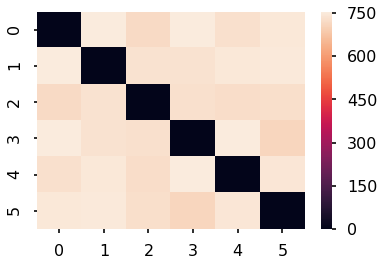

In [123]:
sns.heatmap(squareform(euc_val))

In [121]:
ddf_apn.head().compute()

sample,ERR1092794,ERR1092789,ERR1092790,ERR1092793,ERR1092791,ERR1092792
FBgn,,,,,,
FBgn0000003,3.560136,2.082753,1.763852,2.307798,2.048263,5.146039
FBgn0000008,163.511962,171.566777,162.526319,169.238537,164.885190,165.445168
FBgn0000014,152.068668,162.975421,167.061937,160.263766,153.619742,165.959772
FBgn0000015,335.924265,340.530113,340.927302,352.067441,348.460781,334.749866
FBgn0000017,240.309183,232.226958,227.032889,216.676612,233.502008,219.221281


In [6]:
srx, srr = samples[0]

In [9]:
dfs = [delayed(wrapper)(srx, srr, fname.format(srx=srx, srr=srr)) for srx, srr in samples[:100] if os.path.exists(fname.format(srx=srx, srr=srr))]
ddf = dfs[0].join(dfs[1:])
sample_corr = ddf.corr().compute()

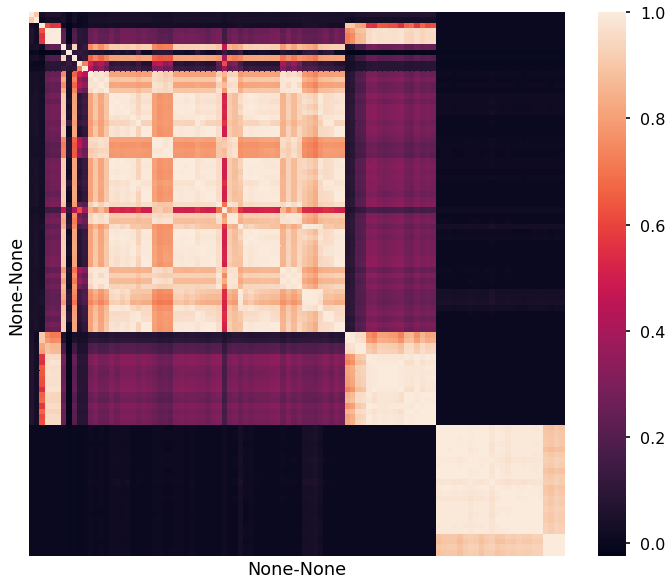

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(sample_corr, xticklabels=False, yticklabels=False, ax=ax)

In [11]:
sample_corr.shape

(100, 100)

In [13]:
ddf.compute().head()

,DRX000774,DRX000775,DRX000998,DRX000999,DRX001000,DRX001001,DRX012753,DRX012754,DRX012755,DRX013093,...,DRX042328,DRX042329,DRX042330,DRX042331,DRX042332,DRX042333,DRX042334,DRX042335,DRX042336,DRX042337
,DRR001177,DRR001178,DRR001444,DRR001445,DRR001446,DRR001447,DRR014222,DRR014223,DRR014224,DRR014573,...,DRR047040,DRR047041,DRR047042,DRR047043,DRR047044,DRR047045,DRR047046,DRR047047,DRR047048,DRR047049
FBgn,,,,,,,,,,,,,,,,,,,,,
FBgn0031081,0,0,679,166,615,460,110,7,62,0,...,0,0,0,0,0,0,0,0,0,0
FBgn0052826,4,2,30,4,10,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FBgn0031085,0,0,221,37,120,85,474,574,267,0,...,0,0,0,0,0,0,0,0,0,0
FBgn0062565,0,0,104,1,17,12,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
FBgn0031088,0,0,446,70,242,179,2,0,4,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
grp = pd.DataFrame(samples, columns=['srx', 'srr']).groupby('srx')

In [35]:
for srx, sd in grp:
    if len(sd['srr'].values) >= 2:
        break

In [36]:
srx

'ERX1172343'

In [39]:
sd['srr'].values

array(['ERR1092789', 'ERR1092790', 'ERR1092791', 'ERR1092792',
       'ERR1092793', 'ERR1092794'], dtype=object)